**Setting up Spark Session on Google Collab**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
!ls

sample_data		   spark-3.1.1-bin-hadoop3.2.tgz
spark-3.1.1-bin-hadoop3.2  XYZ_Bank_Deposit_Data_Classification.csv


In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [5]:
spark

In [6]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

In [7]:
import os
os.getcwd()

'/content'

In [8]:
from platform import python_version
print(python_version())

3.7.15


In [9]:
sc.version #spark version

'3.1.1'

**Read the Project File - Telemarketing Campaign Data**

In [11]:
DataFrame=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("CampaignData.csv")
print("There are",DataFrame.count(),"rows",len(DataFrame.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


**Sample Data - 10 Rows of the Input DataFrame**

In [12]:
DataFrame.show(10)

+---+-----------+-------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job|marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+-----------+-------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid|married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57|   services|married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994| 

There are 21 columns in the Input DataFrame "Campaign Data". This also includes a **target variable 'y'** which shows if a customer has (or not) subscribed to the Term Deposit plan of the bank.

**Datatype of Columns**

In [13]:
DataFrame.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [14]:
DataFrame2 = DataFrame.withColumnRenamed("emp.var.rate","emp_var_rate") \
.withColumnRenamed("cons.price.idx","cons_price_idx") \
.withColumnRenamed("cons.conf.idx",'cons_conf_idx') \
.withColumnRenamed("nr.employed",'nr_employed')

DataFrame2.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



**Checking for NULLs in the Dataset**

In [15]:
from pyspark.sql.functions import isnan, when, count, col
DataFrame2.select([count(when(isnan(col), col)).alias(col) for col in DataFrame2.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Summary Statistics for Numeric Variables**  

In [16]:
num_features = [t[0] for t in DataFrame2.dtypes if t[1] == 'int' or t[1] == 'double']
DataFrame2.select(num_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934036,17,98
duration,41188,258.2850101971448,259.279248836465,0,4918
campaign,41188,2.567592502670681,2.770013542902325,1,56
pdays,41188,962.4754540157328,186.91090734474088,0,999
previous,41188,0.17296299893172767,0.4949010798392903,0,7
emp_var_rate,41188,0.08188550063188142,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.575664368313,0.5788400489540073,92.201,94.767
cons_conf_idx,41188,-40.502600271913245,4.62819785617459,-50.8,-26.9
euribor3m,41188,3.621290812858178,1.7344474048512581,0.634,5.045


**Unique Values of the Categorical Columns**

In [17]:
DataFrame2.select('job').distinct().show()

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+



In [18]:
DataFrame2.select('marital').distinct().show()

+--------+
| marital|
+--------+
| unknown|
|divorced|
| married|
|  single|
+--------+



In [19]:
DataFrame2.select('education').distinct().show()

+-------------------+
|          education|
+-------------------+
|        high.school|
|            unknown|
|           basic.6y|
|professional.course|
|  university.degree|
|         illiterate|
|           basic.4y|
|           basic.9y|
+-------------------+



In [20]:
DataFrame2.select('default').distinct().show()

+-------+
|default|
+-------+
|unknown|
|     no|
|    yes|
+-------+



In [21]:
DataFrame2.select('housing').distinct().show()

+-------+
|housing|
+-------+
|unknown|
|     no|
|    yes|
+-------+



In [22]:
DataFrame2.select('loan').distinct().show()

+-------+
|   loan|
+-------+
|unknown|
|     no|
|    yes|
+-------+



In [23]:
DataFrame2.select('contact').distinct().show()

+---------+
|  contact|
+---------+
| cellular|
|telephone|
+---------+



In [24]:
DataFrame2.select('month').distinct().show()

+-----+
|month|
+-----+
|  jun|
|  aug|
|  may|
|  sep|
|  mar|
|  oct|
|  jul|
|  nov|
|  apr|
|  dec|
+-----+



In [25]:
DataFrame2.select('day_of_week').distinct().show()

+-----------+
|day_of_week|
+-----------+
|        fri|
|        thu|
|        tue|
|        wed|
|        mon|
+-----------+



In [26]:
DataFrame2.select('poutcome').distinct().show()

+-----------+
|   poutcome|
+-----------+
|    success|
|    failure|
|nonexistent|
+-----------+



In [27]:
DataFrame2.select('y').distinct().show()

+---+
|  y|
+---+
| no|
|yes|
+---+



**Feature Distribution using Histogram - For both Categorical and Numeric Columns**

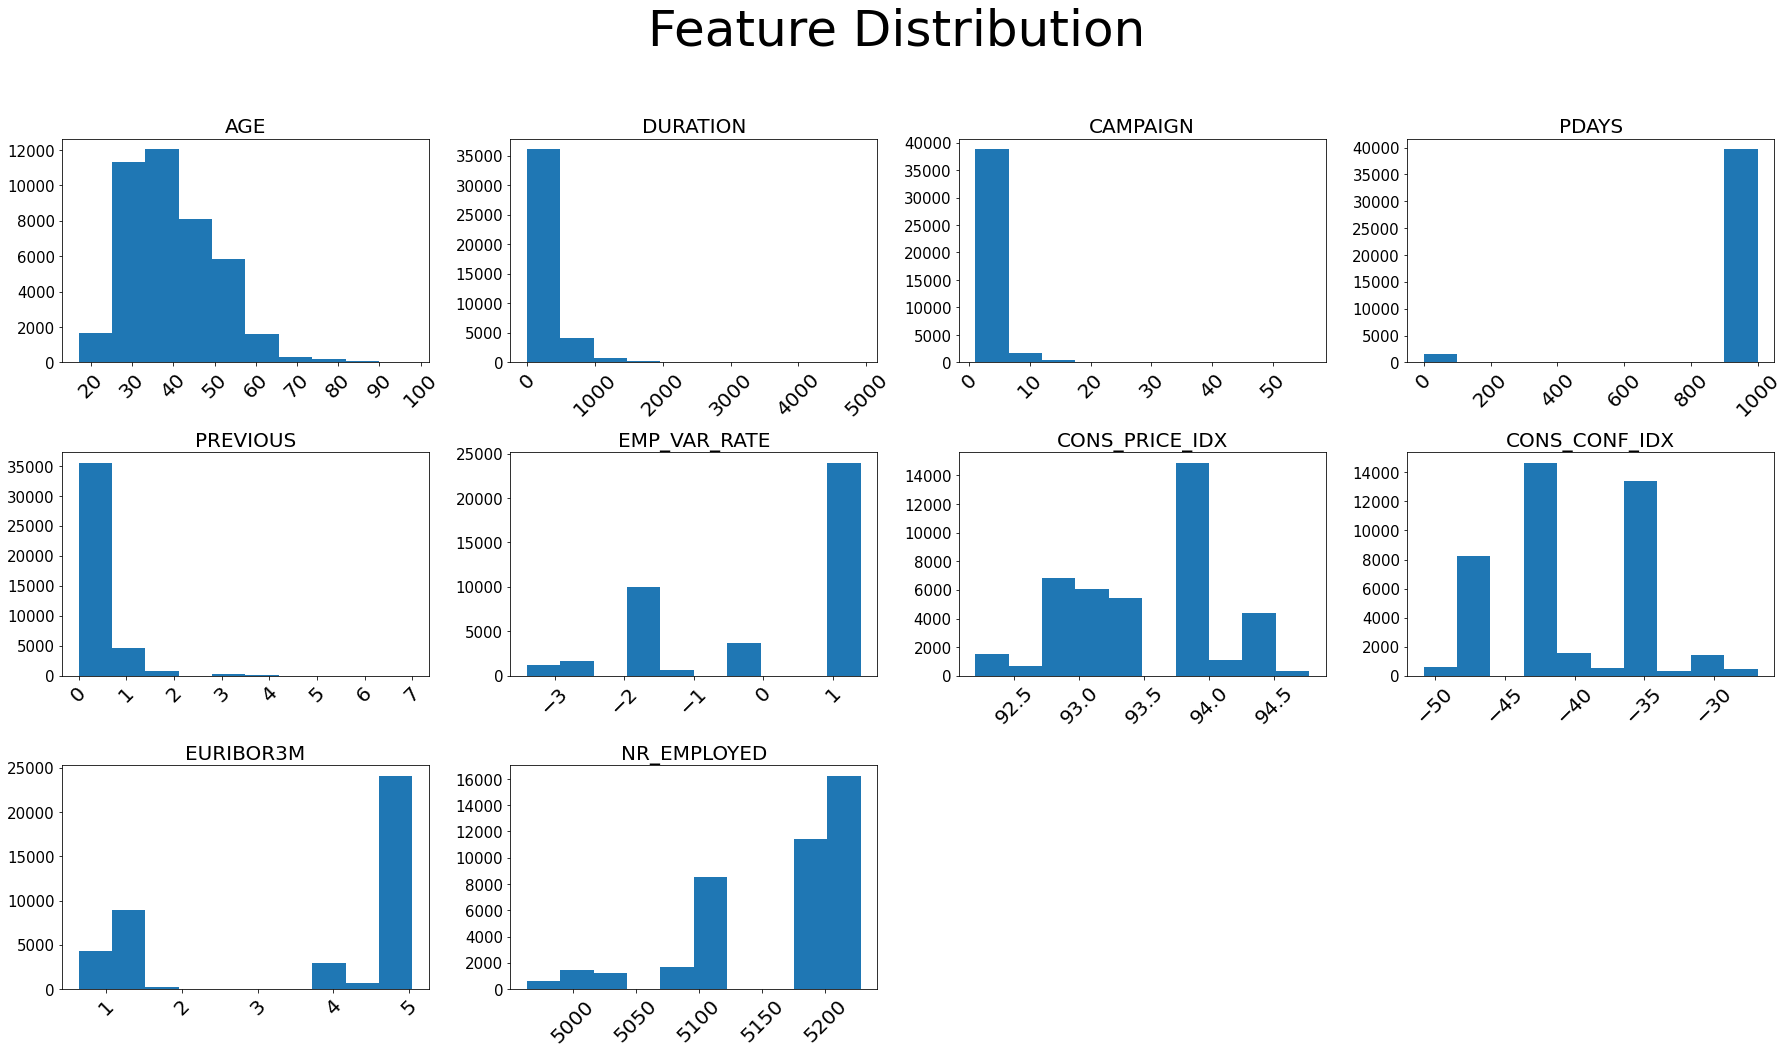

In [28]:
from matplotlib import cm
figure = plt.figure(figsize=(25,15)) ## Plot Size 
title = figure.suptitle("Feature Distribution", fontsize=50,
                  verticalalignment='center') # Plot Title 

for col,num in zip(DataFrame2.toPandas().describe().columns, range(1,11)):
    ax = figure.add_subplot(3,4,num)
    ax.hist(DataFrame2.toPandas()[col])
    #plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
title.set_y(0.95)
figure.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

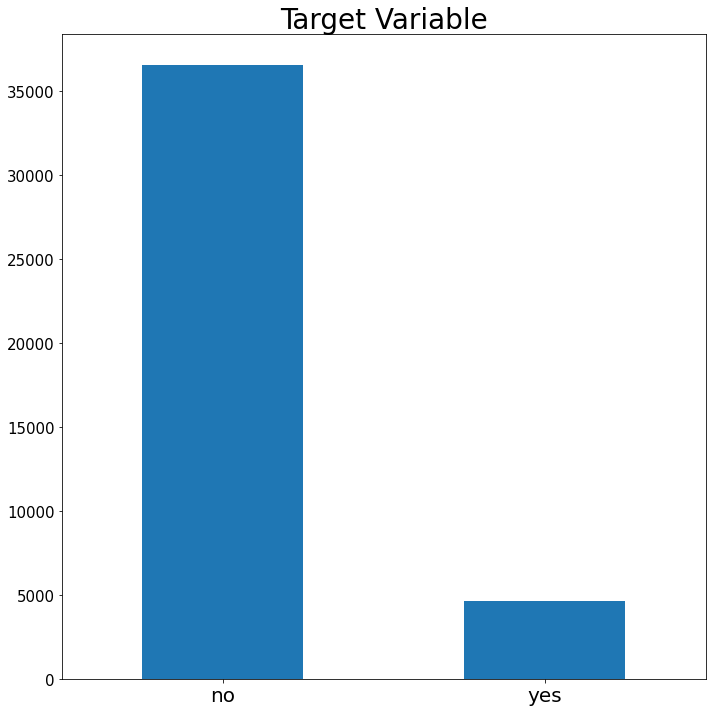

In [29]:
from matplotlib import cm
figure = plt.figure(figsize=(10,10)) ## Plot Size 
#title = figure.suptitle("Feature Distribution", fontsize=50,verticalalignment='center') # Plot Title 

#ax = figure.add_subplot()
DataFrame2.toPandas()['y'].value_counts().plot(kind='bar')
#plt.style.use('dark_background') 
plt.grid(False)
plt.xticks(rotation=0,fontsize=20)
plt.yticks(fontsize=15)
plt.title('Target Variable',fontsize=28)
plt.tight_layout()
title.set_y(0.95)
#figure.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

**Encoding the Categorical Columns** 

In [30]:
encoder = StringIndexer()\
         .setInputCols (["job"])\
         .setOutputCols (["job_encoded"])
Encoder_Model=encoder.fit(DataFrame2)
Encoder_DF=Encoder_Model.transform(DataFrame2)


encoder = StringIndexer()\
         .setInputCols (["marital"])\
         .setOutputCols (["marital_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["education"])\
         .setOutputCols (["education_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["default"])\
         .setOutputCols (["default_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["housing"])\
         .setOutputCols (["housing_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["loan"])\
         .setOutputCols (["loan_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["contact"])\
         .setOutputCols (["contact_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["poutcome"])\
         .setOutputCols (["poutcome_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["month"])\
         .setOutputCols (["month_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)

encoder = StringIndexer()\
         .setInputCols (["day_of_week"])\
         .setOutputCols (["day_of_week_encoded"])
Encoder_Model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_Model.transform(Encoder_DF)


Encoder_DF.toPandas().head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,poutcome_encoded,month_encoded,day_of_week_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,3.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1.0,0.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,2.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
Encoder_DF.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- job_encoded: double (nullable = false)
 |-- marital_encoded: double (nullable = false)
 |-- education_encoded: double (nullable = false)
 |-- default_enc

In [32]:
encoder = StringIndexer()\
         .setInputCols (["y"])\
         .setOutputCols (["y_encoded"])
Encoder_model=encoder.fit(Encoder_DF)
Encoder_DF=Encoder_model.transform(Encoder_DF)

In [33]:
Encoder_DF.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- job_encoded: double (nullable = false)
 |-- marital_encoded: double (nullable = false)
 |-- education_encoded: double (nullable = false)
 |-- default_enc

**Correlations between Numeric Variables** 

In [34]:
CorrInputCols=["age", "duration","campaign", "pdays", "previous", "emp_var_rate","cons_price_idx","cons_conf_idx","nr_employed","euribor3m"]

In [35]:
corr_vect_model = VectorAssembler(inputCols=CorrInputCols,
                          outputCol='vect_features_corrs')

In [36]:
corr_vect_df = corr_vect_model.setHandleInvalid("skip").transform(Encoder_DF)

In [37]:
from pyspark.ml.stat import Correlation

In [38]:
corr_vector_col = 'vect_features_corrs'
matrix = Correlation.corr(corr_vect_df, corr_vector_col)

In [39]:
matrix = Correlation.corr(corr_vect_df, 'vect_features_corrs').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = CorrInputCols, index=CorrInputCols) 
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,nr_employed,euribor3m
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,-0.02,0.01
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.04,-0.03
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.37,0.30
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.50,-0.45
emp_var_rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.91,0.97
cons_price_idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.52,0.69
cons_conf_idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.10,0.28
nr_employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,1.00,0.95
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,0.95,1.00


**Adjusting for Correlations - Removing nr_employed and euribor3m** 

In [40]:
inputCols=['job_encoded', 'marital_encoded', 'education_encoded', 'default_encoded', 'housing_encoded', 'loan_encoded', 'contact_encoded', 'poutcome_encoded',
"age", "duration","campaign", "pdays", "previous", "emp_var_rate","cons_price_idx","cons_conf_idx","month_encoded", "day_of_week_encoded"]


In [41]:
vect_model = VectorAssembler(inputCols=inputCols,
                          outputCol='vect_features')

In [42]:
vect_df = vect_model.setHandleInvalid("skip").transform(Encoder_DF)

In [43]:
# Split data into training (70%) and test (30%)
train, test = vect_df.randomSplit([0.7, 0.3], seed=11)
train.cache()

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: string, job_encoded: double, marital_encoded: double, education_encoded: double, default_encoded: double, housing_encoded: double, loan_encoded: double, contact_encoded: double, poutcome_encoded: double, month_encoded: double, day_of_week_encoded: double, y_encoded: double, vect_features: vector]

**ROC Function for evaluating Classification Algorithms** 

In [44]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

**Model 1 - Logistic Regression** 

In [45]:
from pyspark.ml.classification import LogisticRegression

In [46]:
sample_lr_model = LogisticRegression(featuresCol='vect_features',labelCol='y_encoded')

In [47]:
sample_lr_model_fit = sample_lr_model.fit(train)

In [48]:
sample_lr_model_trans = sample_lr_model_fit.transform(train)

In [49]:
sample_lr_model_trans.select('vect_features','y_encoded','probability', 'prediction').show(3)

+--------------------+---------+--------------------+----------+
|       vect_features|y_encoded|         probability|prediction|
+--------------------+---------+--------------------+----------+
|[10.0,1.0,4.0,0.0...|      0.0|[0.89761423921817...|       0.0|
|[10.0,1.0,4.0,0.0...|      0.0|[0.87600279622145...|       0.0|
|[10.0,1.0,1.0,0.0...|      0.0|[0.96683594363534...|       0.0|
+--------------------+---------+--------------------+----------+
only showing top 3 rows



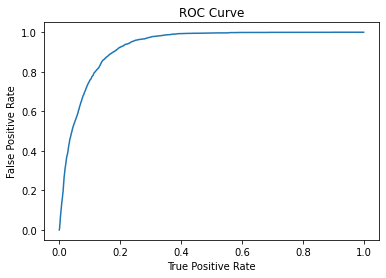

Training set areaUnderROC: 0.9282100822678018


In [50]:
trainingSummary = sample_lr_model_fit.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [51]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [52]:
# Make predictions.
predictions = sample_lr_model_fit.transform(test)

# Select example rows to display.
predictions.select("prediction", "y_encoded", "vect_features").show(5)

+----------+---------+--------------------+
|prediction|y_encoded|       vect_features|
+----------+---------+--------------------+
|       0.0|      1.0|[10.0,1.0,5.0,0.0...|
|       0.0|      0.0|[10.0,1.0,2.0,0.0...|
|       0.0|      0.0|[10.0,1.0,1.0,1.0...|
|       0.0|      0.0|[10.0,1.0,1.0,1.0...|
|       0.0|      0.0|[10.0,1.0,6.0,0.0...|
+----------+---------+--------------------+
only showing top 5 rows



In [53]:
# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(labelCol="y_encoded", rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.6695308631077748


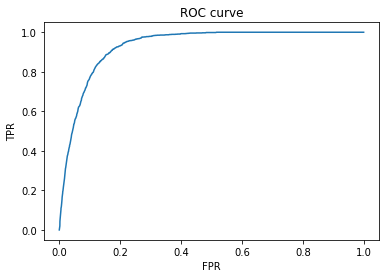

In [54]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('y_encoded','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['y_encoded'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [55]:
# test - AUC Score
metrics = BinaryClassificationMetrics(preds)
metrics.areaUnderROC

0.9310123883397595

In [57]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')



    print(cm)



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, format(cm[i, j], fmt),

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  512   893]
 [  278 10688]]


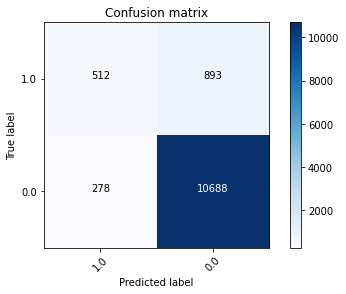

In [58]:
y_true = predictions.select("y_encoded")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')

plt.show()

**Model 2 - Random Forest**

In [59]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [60]:
rf_model = RandomForestClassifier(featuresCol='vect_features',labelCol='y_encoded')

In [61]:
rf_model_fit = rf_model.fit(train)

In [62]:
predictions = rf_model_fit.transform(test)

In [63]:
predictions.select('vect_features','y_encoded','probability', 'prediction').show(3)

+--------------------+---------+--------------------+----------+
|       vect_features|y_encoded|         probability|prediction|
+--------------------+---------+--------------------+----------+
|[10.0,1.0,5.0,0.0...|      1.0|[0.76758139490871...|       0.0|
|[10.0,1.0,2.0,0.0...|      0.0|[0.93133959841295...|       0.0|
|[10.0,1.0,1.0,1.0...|      0.0|[0.93864106458980...|       0.0|
+--------------------+---------+--------------------+----------+
only showing top 3 rows



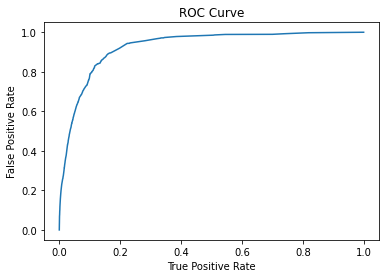

Training set areaUnderROC: 0.9275762747111237


In [64]:
rf_train_summary = rf_model_fit.summary
roc = rf_train_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(rf_train_summary.areaUnderROC))

In [65]:
# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(labelCol="y_encoded", rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.5970096182117097


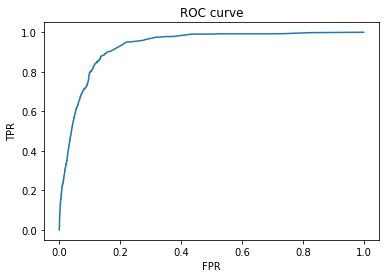

In [66]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('y_encoded','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['y_encoded'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [67]:
# test - AUC Score
metrics = BinaryClassificationMetrics(preds)
metrics.areaUnderROC

0.9295338616999941

Confusion matrix, without normalization
[[  284  1121]
 [   89 10877]]


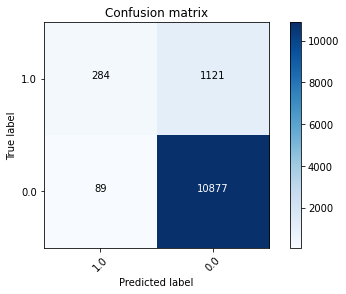

In [68]:
y_true = predictions.select("y_encoded")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')

plt.show()

**Model 3 - Decision Tree**

In [69]:
from pyspark.ml.classification import DecisionTreeClassifier

In [70]:
dtree_model = DecisionTreeClassifier(featuresCol='vect_features',labelCol='y_encoded')
dtree_model_fit = dtree_model.fit(train)
predictions = dtree_model_fit.transform(test)

In [71]:
predictions.select('vect_features','y_encoded','probability', 'prediction').show(3)

+--------------------+---------+--------------------+----------+
|       vect_features|y_encoded|         probability|prediction|
+--------------------+---------+--------------------+----------+
|[10.0,1.0,5.0,0.0...|      1.0|[0.96762463857005...|       0.0|
|[10.0,1.0,2.0,0.0...|      0.0|[0.96762463857005...|       0.0|
|[10.0,1.0,1.0,1.0...|      0.0|[0.96762463857005...|       0.0|
+--------------------+---------+--------------------+----------+
only showing top 3 rows



In [72]:
evaluator = BinaryClassificationEvaluator(labelCol="y_encoded", rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.713379919687056


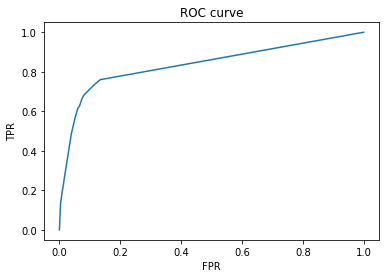

In [73]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('y_encoded','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['y_encoded'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [74]:
# test - AUC Score
metrics = BinaryClassificationMetrics(preds)
metrics.areaUnderROC

0.8365006558609173

Confusion matrix, without normalization
[[  652   753]
 [  409 10557]]


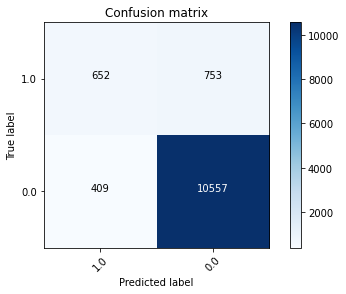

In [75]:
y_true = predictions.select("y_encoded")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')

plt.show()

Model 4 - Gradient Boosting

In [76]:
from pyspark.ml.classification import GBTClassifier

In [77]:
gbt_model = GBTClassifier(featuresCol='vect_features',labelCol='y_encoded')
gbt_model_fit = gbt_model.fit(train)
predictions = gbt_model_fit.transform(test)

In [78]:
evaluator = BinaryClassificationEvaluator(labelCol="y_encoded", rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.7160700528258487


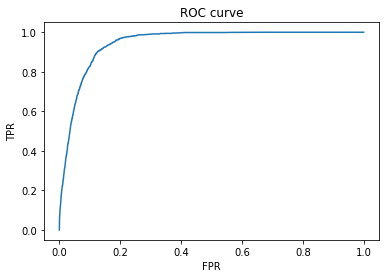

In [79]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('y_encoded','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['y_encoded'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [80]:
# test - AUC Score
metrics = BinaryClassificationMetrics(preds)
metrics.areaUnderROC

0.945410855812498

Confusion matrix, without normalization
[[  652   753]
 [  350 10616]]


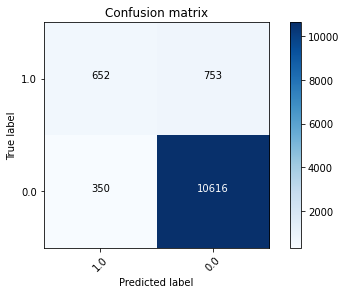

In [81]:
y_true = predictions.select("y_encoded")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')

plt.show()

**K - Means Clustering**

In [82]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='vect_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='vect_features', k=i)
    KMeans_fit=KMeans_algo.fit(vect_df)
    
    output=KMeans_fit.transform(vect_df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.7863877588415096
Silhouette Score: 0.8653167166226732
Silhouette Score: 0.8015746755864427
Silhouette Score: 0.7783364702474375
Silhouette Score: 0.7471059819819847
Silhouette Score: 0.7188121025320332
Silhouette Score: 0.7135363891012293
Silhouette Score: 0.7092959911980926


Text(0, 0.5, 'Silhouette Score')

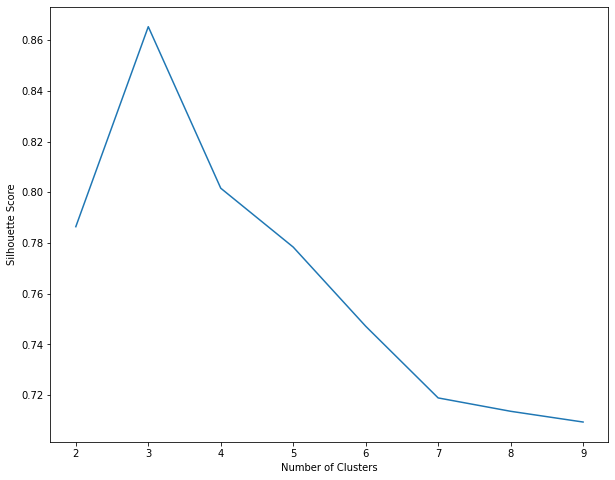

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [87]:
gbt_model_fit.save("FinalModel")

In [88]:
!zip -r /content/FinalModel.zip /content/FinalModel

  adding: content/FinalModel/ (stored 0%)
  adding: content/FinalModel/metadata/ (stored 0%)
  adding: content/FinalModel/metadata/_SUCCESS (stored 0%)
  adding: content/FinalModel/metadata/part-00000 (deflated 43%)
  adding: content/FinalModel/metadata/._SUCCESS.crc (stored 0%)
  adding: content/FinalModel/metadata/.part-00000.crc (stored 0%)
  adding: content/FinalModel/data/ (stored 0%)
  adding: content/FinalModel/data/part-00000-3918a0c5-1a3e-4c59-a4ce-1e085952b796-c000.snappy.parquet (deflated 14%)
  adding: content/FinalModel/data/_SUCCESS (stored 0%)
  adding: content/FinalModel/data/.part-00001-3918a0c5-1a3e-4c59-a4ce-1e085952b796-c000.snappy.parquet.crc (stored 0%)
  adding: content/FinalModel/data/._SUCCESS.crc (stored 0%)
  adding: content/FinalModel/data/.part-00000-3918a0c5-1a3e-4c59-a4ce-1e085952b796-c000.snappy.parquet.crc (stored 0%)
  adding: content/FinalModel/data/part-00001-3918a0c5-1a3e-4c59-a4ce-1e085952b796-c000.snappy.parquet (deflated 13%)
  adding: content/Fi

In [90]:
from google.colab import files
files.download("/content/FinalModel.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>